In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/Yeominrak


In [2]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch
from collections import defaultdict, Counter
import copy
import numpy as np

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore, TestScore
from model_zoo import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from trainer import Trainer
from decode import MidiDecoder
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
from metric import make_dynamic_template, convert_note_to_sampling, get_similarity, get_correspondence
from constants import get_dynamic

In [3]:
config = OmegaConf.load('yamls/baseline.yaml')
config = get_emb_total_size(config)
device = 'cpu'
val_dataset = ShiftedAlignedScore(is_valid= True, slice_measure_num=4, feature_types=config.model.features)
valid_loader = DataLoader(val_dataset, batch_size=4, collate_fn=pack_collate, shuffle=False)
model = QkvAttnSeq2seq(val_dataset.tokenizer, config.model).to(device)
# state = torch.load('best_model.pt')
state = torch.load('outputs/2023-12-11/00-14-46/best_model.pt')
model.load_state_dict(state)
decoder = MidiDecoder(val_dataset.tokenizer)


In [16]:
from fractions import Fraction
{Fraction(k).limit_denominator(3):v  for k, v in model.tokenizer.tok2idx['offset'].items() if type(k)==float}

{Fraction(0, 1): 3,
 Fraction(1, 2): 4,
 Fraction(1, 1): 5,
 Fraction(3, 2): 6,
 Fraction(2, 1): 7,
 Fraction(7, 3): 8,
 Fraction(5, 2): 9,
 Fraction(8, 3): 10,
 Fraction(3, 1): 11,
 Fraction(10, 3): 12,
 Fraction(7, 2): 13,
 Fraction(11, 3): 14,
 Fraction(4, 1): 15,
 Fraction(13, 3): 16,
 Fraction(9, 2): 17,
 Fraction(14, 3): 18,
 Fraction(5, 1): 19,
 Fraction(11, 2): 20,
 Fraction(17, 3): 21,
 Fraction(6, 1): 22,
 Fraction(13, 2): 23,
 Fraction(20, 3): 24,
 Fraction(7, 1): 25,
 Fraction(22, 3): 26,
 Fraction(15, 2): 27,
 Fraction(23, 3): 28,
 Fraction(8, 1): 29,
 Fraction(17, 2): 30,
 Fraction(26, 3): 31,
 Fraction(9, 1): 32,
 Fraction(28, 3): 33,
 Fraction(19, 2): 34,
 Fraction(29, 3): 35}

In [30]:
from fractions import Fraction


Fraction(1,3) + 4

Fraction(13, 3)

In [43]:
from fractions import Fraction

float_value = 1.333
fraction_value = Fraction(float_value).limit_denominator(3)
numerator = fraction_value.numerator
denominator = fraction_value.denominator

print(numerator, denominator)  # Output: 4 3


4 3


In [44]:
[Fraction(offset).limit_denominator(3) for offset in model.tokenizer.vocab['offset'] if type(offset)==float]

[Fraction(0, 1),
 Fraction(1, 2),
 Fraction(1, 1),
 Fraction(3, 2),
 Fraction(2, 1),
 Fraction(7, 3),
 Fraction(5, 2),
 Fraction(8, 3),
 Fraction(3, 1),
 Fraction(10, 3),
 Fraction(7, 2),
 Fraction(11, 3),
 Fraction(4, 1),
 Fraction(13, 3),
 Fraction(9, 2),
 Fraction(14, 3),
 Fraction(5, 1),
 Fraction(11, 2),
 Fraction(17, 3),
 Fraction(6, 1),
 Fraction(13, 2),
 Fraction(20, 3),
 Fraction(7, 1),
 Fraction(22, 3),
 Fraction(15, 2),
 Fraction(23, 3),
 Fraction(8, 1),
 Fraction(17, 2),
 Fraction(26, 3),
 Fraction(9, 1),
 Fraction(28, 3),
 Fraction(19, 2),
 Fraction(29, 3)]

In [23]:
sample = val_dataset[48][0]
src, out, _ = model.shifted_inference(sample, 6)

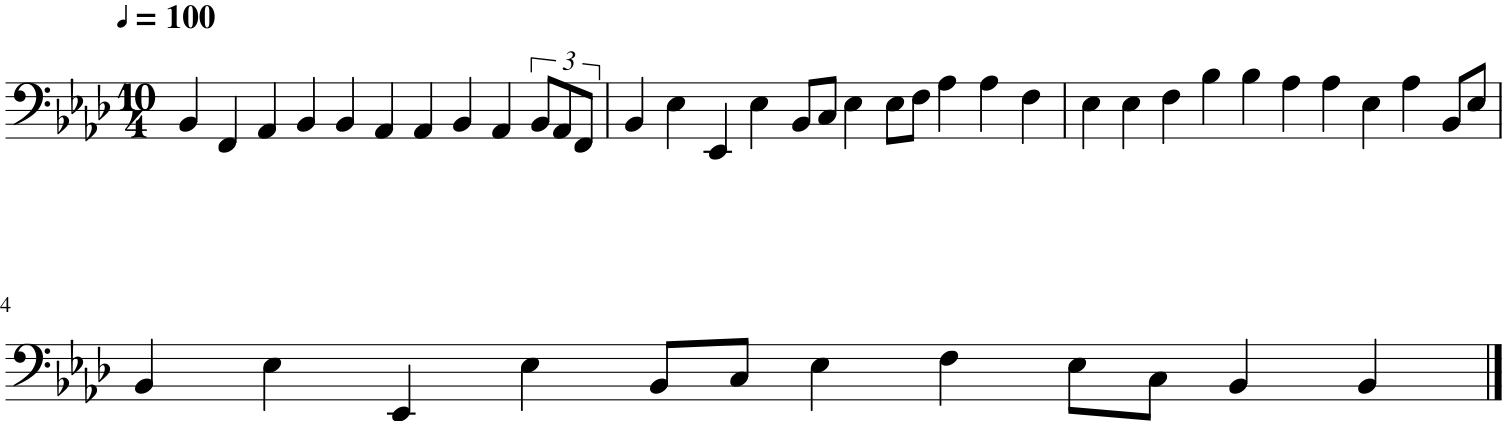

In [28]:
stream_result = decoder(out)
# for note in stream_result.notesAndRests():
#   # print(note.pitch.accidental.displayStatus)
#   # note.pitch.accidental.displayStatus = None
#   # print(type(note.pitch.accidental))
#   if note.pitch.accidental.alter == 0:
#     print(note.pitch)
#     note.pitch.accidental = None
#   # note.pitch.accidental = None
  # pass
stream_result.show()

In [24]:
model.tokenizer.tok2idx['offset']

{'pad': 0,
 'start': 1,
 'end': 2,
 0.0: 3,
 0.5: 4,
 1.0: 5,
 1.5: 6,
 2.0: 7,
 2.333: 8,
 2.5: 9,
 2.666: 10,
 3.0: 11,
 3.333: 12,
 3.5: 13,
 3.666: 14,
 4.0: 15,
 4.333: 16,
 4.5: 17,
 4.666: 18,
 5.0: 19,
 5.5: 20,
 5.666: 21,
 6.0: 22,
 6.5: 23,
 6.666: 24,
 7.0: 25,
 7.333: 26,
 7.5: 27,
 7.666: 28,
 8.0: 29,
 8.5: 30,
 8.666: 31,
 9.0: 32,
 9.333: 33,
 9.5: 34,
 9.666: 35}

In [4]:
test_set = TestScore(xml_path='chihwapyung.musicxml', is_valid=True, 
                     valid_measure_num=[i for i in range(509)], slice_measure_num=4, transpose=+3)
test_set.tokenizer = val_dataset.tokenizer

In [189]:
test_set.measure_features[0]

[[[0, 51.0, 5.0, 0, 'strong', 1], [0, 51.0, 3.0, 5.0, 'strong', 0]],
 [[0, 53.0, 5.0, 0.0, 'strong', 1], [0, 51.0, 3.0, 5.0, 'strong', 0]],
 [[0, 56.0, 3.0, 0.0, 'strong', 1],
  [0, 53.0, 2.0, 3.0, 'middle', 0],
  [0, 51.0, 3.0, 5.0, 'strong', 0]],
 [[0, 51.0, 5.0, 0.0, 'strong', 1], [0, 51.0, 3.0, 5.0, 'strong', 0]],
 [[0, 51.0, 5.0, 0.0, 'strong', 1], [0, 56.0, 3.0, 5.0, 'strong', 0]],
 [[0, 53.0, 3.0, 0.0, 'strong', 1],
  [0, 51.0, 2.0, 3.0, 'middle', 0],
  [0, 48.0, 3.0, 5.0, 'strong', 0]],
 [[0, 46.0, 3.0, 0.0, 'strong', 1],
  [0, 48.0, 2.0, 3.0, 'middle', 0],
  [0, 46.0, 3.0, 5.0, 'strong', 0]],
 [[0, 51.0, 5.0, 0.0, 'strong', 1], [0, 48.0, 3.0, 5.0, 'strong', 0]],
 [[0, 46.0, 3.0, 0.0, 'strong', 1],
  [0, 51.0, 2.0, 3.0, 'middle', 0],
  [0, 53.0, 1.0, 5.0, 'strong', 0],
  [0, 51.0, 2.0, 6.0, 'weak', 0]],
 [[0, 48, 5.0, 0.0, 'strong', 1], [0, 46.0, 3.0, 5.0, 'strong', 0]],
 [[0, 44.0, 5.0, 0.0, 'strong', 1], [0, 44.0, 3.0, 5.0, 'strong', 0]],
 [[0, 41.0, 5.0, 0.0, 'strong', 1], [

In [5]:
import copy
from yeominrak_processing import SimpleNote

flattened_notes = [SimpleNote(note) for measure in test_set.parts[0].measures for note in measure]
print(f"len of flattened notes: {len(flattened_notes)}")
measure_shifted_notes = []
for note in flattened_notes:
  new_offset = (note.measure_offset - 1.5 )
  new_note = None
  if note.duration > 4:
    break
  if new_offset < 0:
    new_offset += 4
    note.measure_number -= 1
    note.end_measure_number -= 1
    if note.measure_number <= 0:
      new_note = copy.copy(note)
      new_note.measure_offset = 0
      new_note.duration = 4 - note.duration
      measure_shifted_notes.append(new_note)
      new_note = None
  note.measure_offset = new_offset
  if note.measure_offset + note.duration > 4:
    # print("note duration is too long", note.measure_offset, note.duration)
    extended_duration = note.measure_offset + note.duration - 4
    note.duration -= extended_duration
    new_note = copy.copy(note)
    new_note.measure_offset = 0
    new_note.measure_number += 1
    new_note.end_measure_number += 1
    new_note.duration = extended_duration
  measure_shifted_notes.append(note)
  if new_note:
    measure_shifted_notes.append(new_note)
new_note = copy.copy(note)
new_note.measure_offset += note.duration
new_note.duration = 1.5
measure_shifted_notes.append(new_note)

measure_shifted_notes.sort(key=lambda x: (x.measure_number, x.measure_offset))

print(f"len of measure shifted notes: {len(measure_shifted_notes)}")
  

len of flattened notes: 1241
len of measure shifted notes: 1613


In [162]:
note

SimpleNote: P:48.0, D:1.5, M:508, MO: 1.0, Dyn: weak

In [166]:
note_by_measure = []
temp_measure = []
prev_measure_number = 0
for note in measure_shifted_notes:
  if note.measure_number != prev_measure_number:
    note_by_measure.append(temp_measure)
    temp_measure = []
    prev_measure_number = note.measure_number
  temp_measure.append(note)
note_by_measure.append(temp_measure)



In [167]:
note_by_measure

[[],
 [SimpleNote: P:48.0, D:1.5, M:-1, MO: 0, Dyn: strong,
  SimpleNote: P:48.0, D:1.5, M:-1, MO: 2.5, Dyn: strong],
 [SimpleNote: P:48.0, D:1.0, M:0, MO: 0, Dyn: strong,
  SimpleNote: P:50.0, D:1.5, M:0, MO: 0, Dyn: strong,
  SimpleNote: P:48.0, D:1.5, M:0, MO: 1.0, Dyn: weak,
  SimpleNote: P:50.0, D:1.5, M:0, MO: 2.5, Dyn: strong],
 [SimpleNote: P:50.0, D:1.0, M:1, MO: 0, Dyn: strong,
  SimpleNote: P:48.0, D:1.5, M:1, MO: 1.0, Dyn: weak,
  SimpleNote: P:53.0, D:1.5, M:1, MO: 2.5, Dyn: strong],
 [SimpleNote: P:50.0, D:1.0, M:2, MO: 0.0, Dyn: strong,
  SimpleNote: P:48.0, D:1.5, M:2, MO: 1.0, Dyn: weak,
  SimpleNote: P:48.0, D:1.5, M:2, MO: 2.5, Dyn: strong],
 [SimpleNote: P:48.0, D:1.0, M:3, MO: 0, Dyn: strong,
  SimpleNote: P:48.0, D:1.5, M:3, MO: 1.0, Dyn: weak,
  SimpleNote: P:48.0, D:1.5, M:3, MO: 2.5, Dyn: strong],
 [SimpleNote: P:48.0, D:1.0, M:4, MO: 0, Dyn: strong,
  SimpleNote: P:53.0, D:1.5, M:4, MO: 1.0, Dyn: weak,
  SimpleNote: P:50.0, D:1.5, M:4, MO: 2.5, Dyn: strong],
 

In [7]:
measure_shifted_notes[:10]

{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 2.5
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 0.0
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 2.5
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 0.0
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 1.5
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 2.5
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 0.0
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 2.5
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 0.0
{0.0: 'strong', 2.5: 'strong', 1.5: 'middle'} 2.5


[SimpleNote: P:48.0, D:1.5, M:0, MO: 2.5, Dyn: strong,
 SimpleNote: P:50.0, D:2.5, M:1, MO: 0.0, Dyn: strong,
 SimpleNote: P:48.0, D:1.5, M:1, MO: 2.5, Dyn: strong,
 SimpleNote: P:53.0, D:1.5, M:2, MO: 0.0, Dyn: strong,
 SimpleNote: P:50.0, D:1.0, M:2, MO: 1.5, Dyn: middle,
 SimpleNote: P:48.0, D:1.5, M:2, MO: 2.5, Dyn: strong,
 SimpleNote: P:48.0, D:2.5, M:3, MO: 0.0, Dyn: strong,
 SimpleNote: P:48.0, D:1.5, M:3, MO: 2.5, Dyn: strong,
 SimpleNote: P:48.0, D:2.5, M:4, MO: 0.0, Dyn: strong,
 SimpleNote: P:53.0, D:1.5, M:4, MO: 2.5, Dyn: strong]

In [ ]:
set([note[1] for measure in test_set.measure_features[0] for note in measure])


In [ ]:
test_set[0]

In [35]:
for i in range(len(test_set)):
  test_set[i]

In [32]:
len(test_set.slice_info), len(test_set)

(61, 549)

[[0, 1, [0, 1, 2, 3]],
 [0, 1, [1, 2, 3, 4]],
 [0, 1, [2, 3, 4, 5]],
 [0, 1, [3, 4, 5, 6]],
 [0, 1, [4, 5, 6, 7]],
 [0, 1, [5, 6, 7, 8]],
 [0, 1, [6, 7, 8, 9]],
 [0, 1, [7, 8, 9, 10]],
 [0, 1, [8, 9, 10, 11]],
 [0, 1, [9, 10, 11, 12]],
 [0, 1, [10, 11, 12, 13]],
 [0, 1, [11, 12, 13, 14]],
 [0, 1, [12, 13, 14, 15]],
 [0, 1, [13, 14, 15, 16]],
 [0, 1, [14, 15, 16, 17]],
 [0, 1, [15, 16, 17, 18]],
 [0, 1, [16, 17, 18, 19]],
 [0, 1, [17, 18, 19, 20]],
 [0, 1, [18, 19, 20, 21]],
 [0, 1, [19, 20, 21, 22]],
 [0, 1, [20, 21, 22, 23]],
 [0, 1, [21, 22, 23, 24]],
 [0, 1, [22, 23, 24, 25]],
 [0, 1, [23, 24, 25, 26]],
 [0, 1, [24, 25, 26, 27]],
 [0, 1, [25, 26, 27, 28]],
 [0, 1, [26, 27, 28, 29]],
 [0, 1, [27, 28, 29, 30]],
 [0, 1, [28, 29, 30, 31]],
 [0, 1, [29, 30, 31, 32]],
 [0, 1, [30, 31, 32, 33]],
 [0, 1, [31, 32, 33, 34]],
 [0, 1, [32, 33, 34, 35]],
 [0, 1, [33, 34, 35, 36]],
 [0, 1, [34, 35, 36, 37]],
 [0, 1, [35, 36, 37, 38]],
 [0, 1, [36, 37, 38, 39]],
 [0, 1, [37, 38, 39, 40]],
 [0, 1, 

0
tensor([[ 1,  1,  1,  1,  1,  1],
        [ 1, 11, 10,  3,  3,  4],
        [ 1, 13,  7,  7,  5,  3],
        [ 1, 11, 10, 11,  4,  3],
        [ 1, 10,  7, 19,  3,  3],
        [ 1, 11,  7, 22,  5,  3],
        [ 1, 10,  7, 25,  5,  3],
        [ 1, 11, 10,  3,  3,  4],
        [ 1, 13,  7,  7,  5,  3],
        [ 1, 11, 10, 11,  4,  3],
        [ 1, 10,  7, 19,  3,  3],
        [ 1, 11,  7, 22,  5,  3],
        [ 1, 10,  7, 25,  5,  3],
        [ 1, 10, 14,  3,  3,  4],
        [ 1, 10, 12, 19,  3,  3],
        [ 1, 10, 10,  3,  3,  4],
        [ 1, 10,  7,  7,  5,  3],
        [ 1, 11, 10, 11,  4,  3],
        [ 1, 13,  7, 19,  3,  3],
        [ 1, 13,  7, 22,  5,  3],
        [ 1, 10,  7, 25,  5,  3],
        [ 1,  2,  2,  2,  2,  2]])
1
tensor([[ 2,  1,  1,  1,  1,  1],
        [ 2, 11, 10,  3,  3,  4],
        [ 2, 13,  7,  7,  5,  3],
        [ 2, 11, 12, 11,  4,  3],
        [ 2, 10, 10, 22,  3,  3],
        [ 2, 11,  7, 29,  4,  3],
        [ 2, 10,  7, 32,  5,  3],
        [

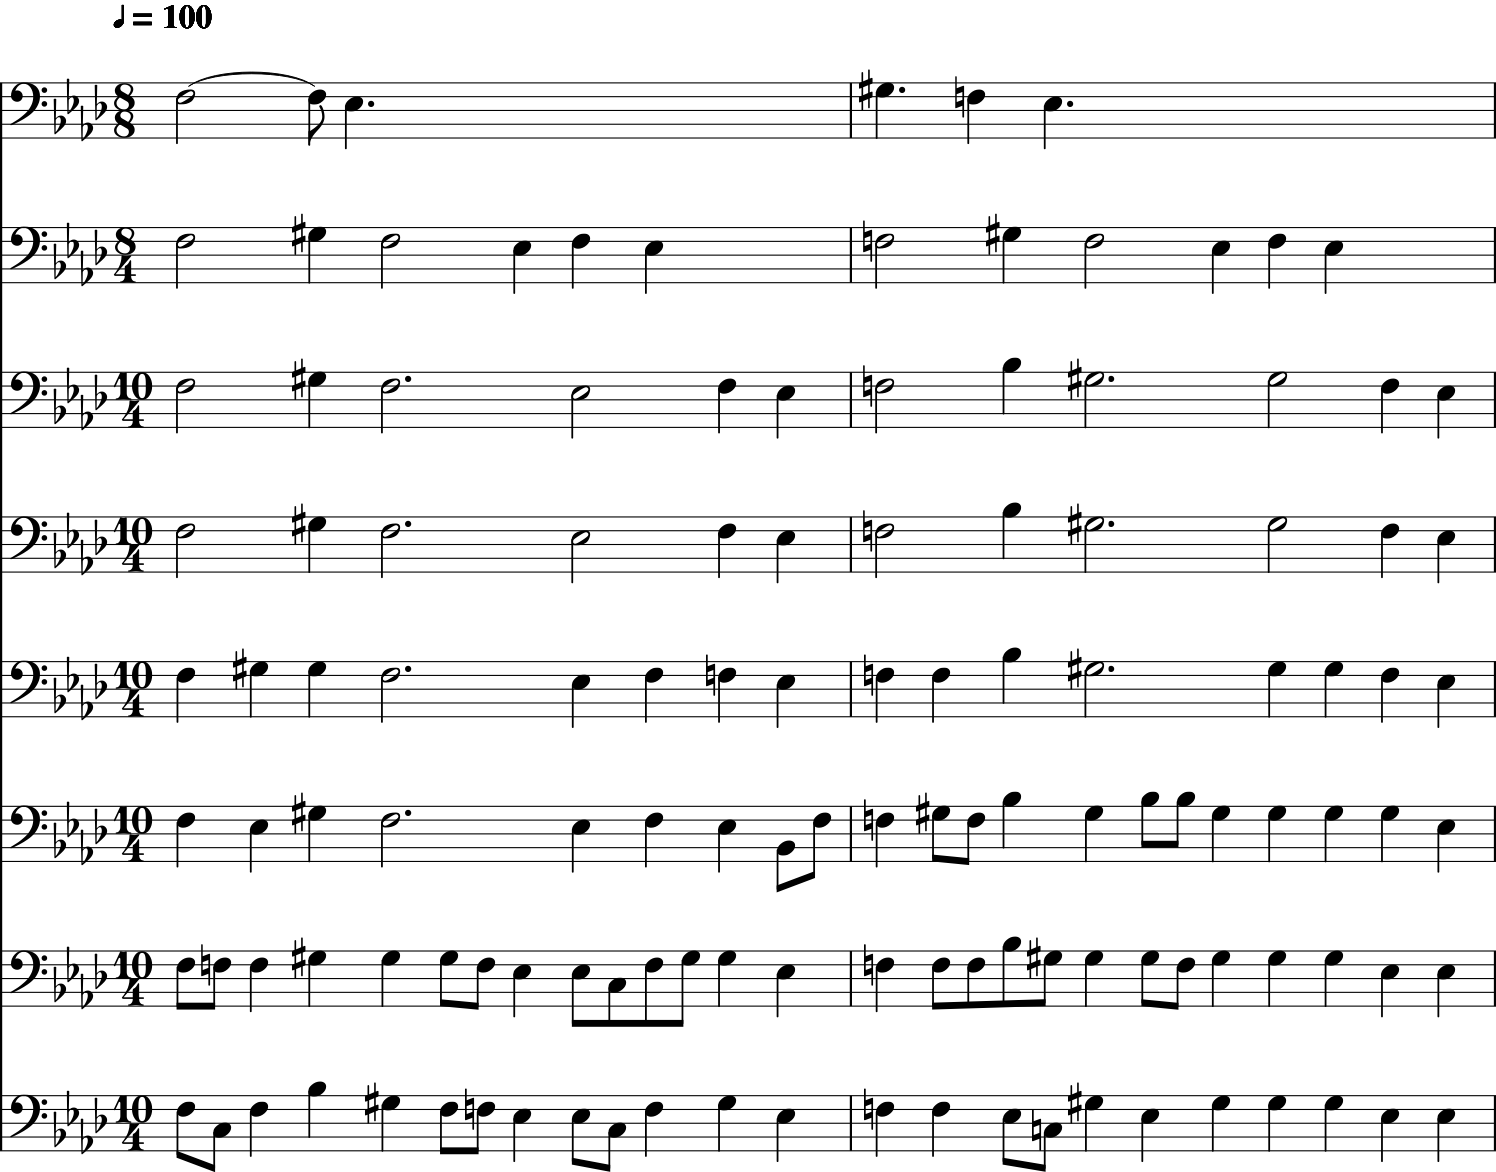

PosixPath('/home/teo/userdata/git_libraries/Yeominrak/sequential_inf_segment-1.png')

In [25]:
sample = test_set[1]
sample[:,0] = 0

def sequential_inference(model, sample, decoder):
  s = stream.Score(id='mainScore')
  
  output_part_idx = 1
  for i in range(8-output_part_idx):    
    src, output, attention_map = model.shifted_inference(sample, output_part_idx)
    if i == 0:
      merged_part = stream.Part() 
      src_midi = decoder(src)
      for element in src_midi:
        merged_part.append(element)
      s.insert(0, merged_part)
    print(i)
    output_midi = decoder(output)
    merged_part = stream.Part() 
    for element in output_midi:
      merged_part.append(element)
    s.insert(0, merged_part)
    pred, condition = [note[:3] for note in output], [note[3:] for note in output]
    output = [pred[0] + [0, 'strong', 1]] + [pr + con for pr, con in zip(pred[1:], condition[:-1])] + [[output_part_idx, 'end', 'end', 'end', 'end', 'end']]
    output = [[output_part_idx, 'start', 'start', 'start', 'start', 'start']] + output
    sample = [val_dataset.tokenizer(note) for note in output]
    sample = torch.Tensor(sample).long()
    print(sample)
    output_part_idx += 1

  return s

# src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, 2)

out_midi = sequential_inference(model, sample, decoder=decoder)
out_midi.show()
out_midi.write('musicxml.png', fp='sequential_inf_segment.png')

In [6]:
def get_measure_shifted_output(output: torch.Tensor):
  for i, token in enumerate(output):
    if token[-1] == 4: # new measure started:
      break
  # start_token = torch.LongTensor([[part_idx, 1, 1, 3, 3, 4]]) 
  output_tokens_from_second_measure = output[i:-1].clone()
  output_tokens_from_second_measure[0, 1] = 1
  output_tokens_from_second_measure[0, 2] = 1
  return output_tokens_from_second_measure
# output_tokens = output_tokens_from_second_measure
# prev_generation = get_measure_shifted_output(output)

In [7]:
prev_generation = None
outputs = []
for i in range(len(test_set)):
# for i in range(50):
  # merged_midi = stream.Stream()
  sample = test_set[i]
  sample[:,0] = 1
  src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, 2, prev_generation=prev_generation)

  # src_midi = decoder(src)
  # for element in src_midi:
  #   merged_midi.append(element)
  # output_midi = decoder(output_decoded)
  # for element in output_midi:
  #   merged_midi.append(element)
  if prev_generation is not None:
    new_out = new_out[1:]
  prev_generation = get_measure_shifted_output(output)
  outputs.append(new_out)
  print(i, (new_out[:,-1]==4).sum().item())

outputs_tensor = torch.cat(outputs, dim=0)

0 4
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 2
85 0
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 2
124 0
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1
153 1
154 1
155 1
156 1
157 1
158 1
159 1
160 1
161 1
162 1
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 1
173 1
174 1
175 1
176 1
177 1
178 1
179 1
180 1
181 1
182 1
183 1
184 1


In [32]:
len(test_set.parts[0].measures)

509

In [31]:
(outputs_tensor[:,-1] == 4).sum().item()

509

In [221]:
new_out

tensor([[ 2, 11,  7,  3,  3,  4],
        [ 2, 10, 10,  7,  5,  3],
        [ 2,  8,  7, 11,  4,  3],
        [ 2, 10, 12, 22,  3,  3],
        [ 2, 13, 10, 29,  4,  3],
        [ 2, 11,  7, 32,  5,  3],
        [ 2, 10,  7,  3,  3,  4]])

In [172]:
test_set.result_pairs[57]

[0, 1, [57, 58, 59, 60]]

In [176]:
test_set.parts[0].measures[60]

[SimpleNote: P:43.0, D:2.5, M:60, MO: 0.0, Dyn: strong,
 SimpleNote: P:53.0, D:1.5, M:60, MO: 2.5, Dyn: strong]

In [117]:
model.shifted_inference(sample, 2, prev_generation=prev_generation)

RuntimeError: stack expects a non-empty TensorList

In [225]:
outputs_tensor[:100]

tensor([[ 2, 10, 12, 11,  4,  3],
        [ 2, 10, 12, 22,  3,  3],
        [ 2, 10, 10, 29,  4,  3],
        [ 2,  8,  7, 32,  5,  3],
        [ 2,  7,  7,  3,  3,  4],
        [ 2, 11, 10,  7,  5,  3],
        [ 2, 11,  7, 11,  4,  3],
        [ 2, 13, 12, 22,  3,  3],
        [ 2, 13,  7, 25,  5,  3],
        [ 2, 11,  7, 29,  4,  3],
        [ 2, 10,  7, 32,  5,  3],
        [ 2,  8,  7,  3,  3,  4],
        [ 2, 13, 12, 11,  4,  3],
        [ 2, 13, 12, 22,  3,  3],
        [ 2, 13, 10, 29,  4,  3],
        [ 2, 11,  7, 32,  5,  3],
        [ 2, 10,  7,  3,  3,  4],
        [ 2, 13, 10,  7,  5,  3],
        [ 2, 11,  7, 11,  4,  3],
        [ 2, 10, 12, 22,  3,  3],
        [ 2, 13, 10, 29,  4,  3],
        [ 2, 10,  7, 32,  5,  3],
        [ 2, 10,  7,  3,  3,  4],
        [ 2, 10,  7,  3,  3,  4],
        [ 2, 13, 12, 11,  4,  3],
        [ 2, 13, 12, 22,  3,  3],
        [ 2, 13,  7, 25,  5,  3],
        [ 2, 13,  7, 29,  4,  3],
        [ 2, 13,  7, 32,  5,  3],
        [ 2, 1

In [200]:
torch.cat([pred[0:1], torch.tensor([[3,3,4]])], dim=1)

tensor([[ 2, 10, 12,  3,  3,  4]])

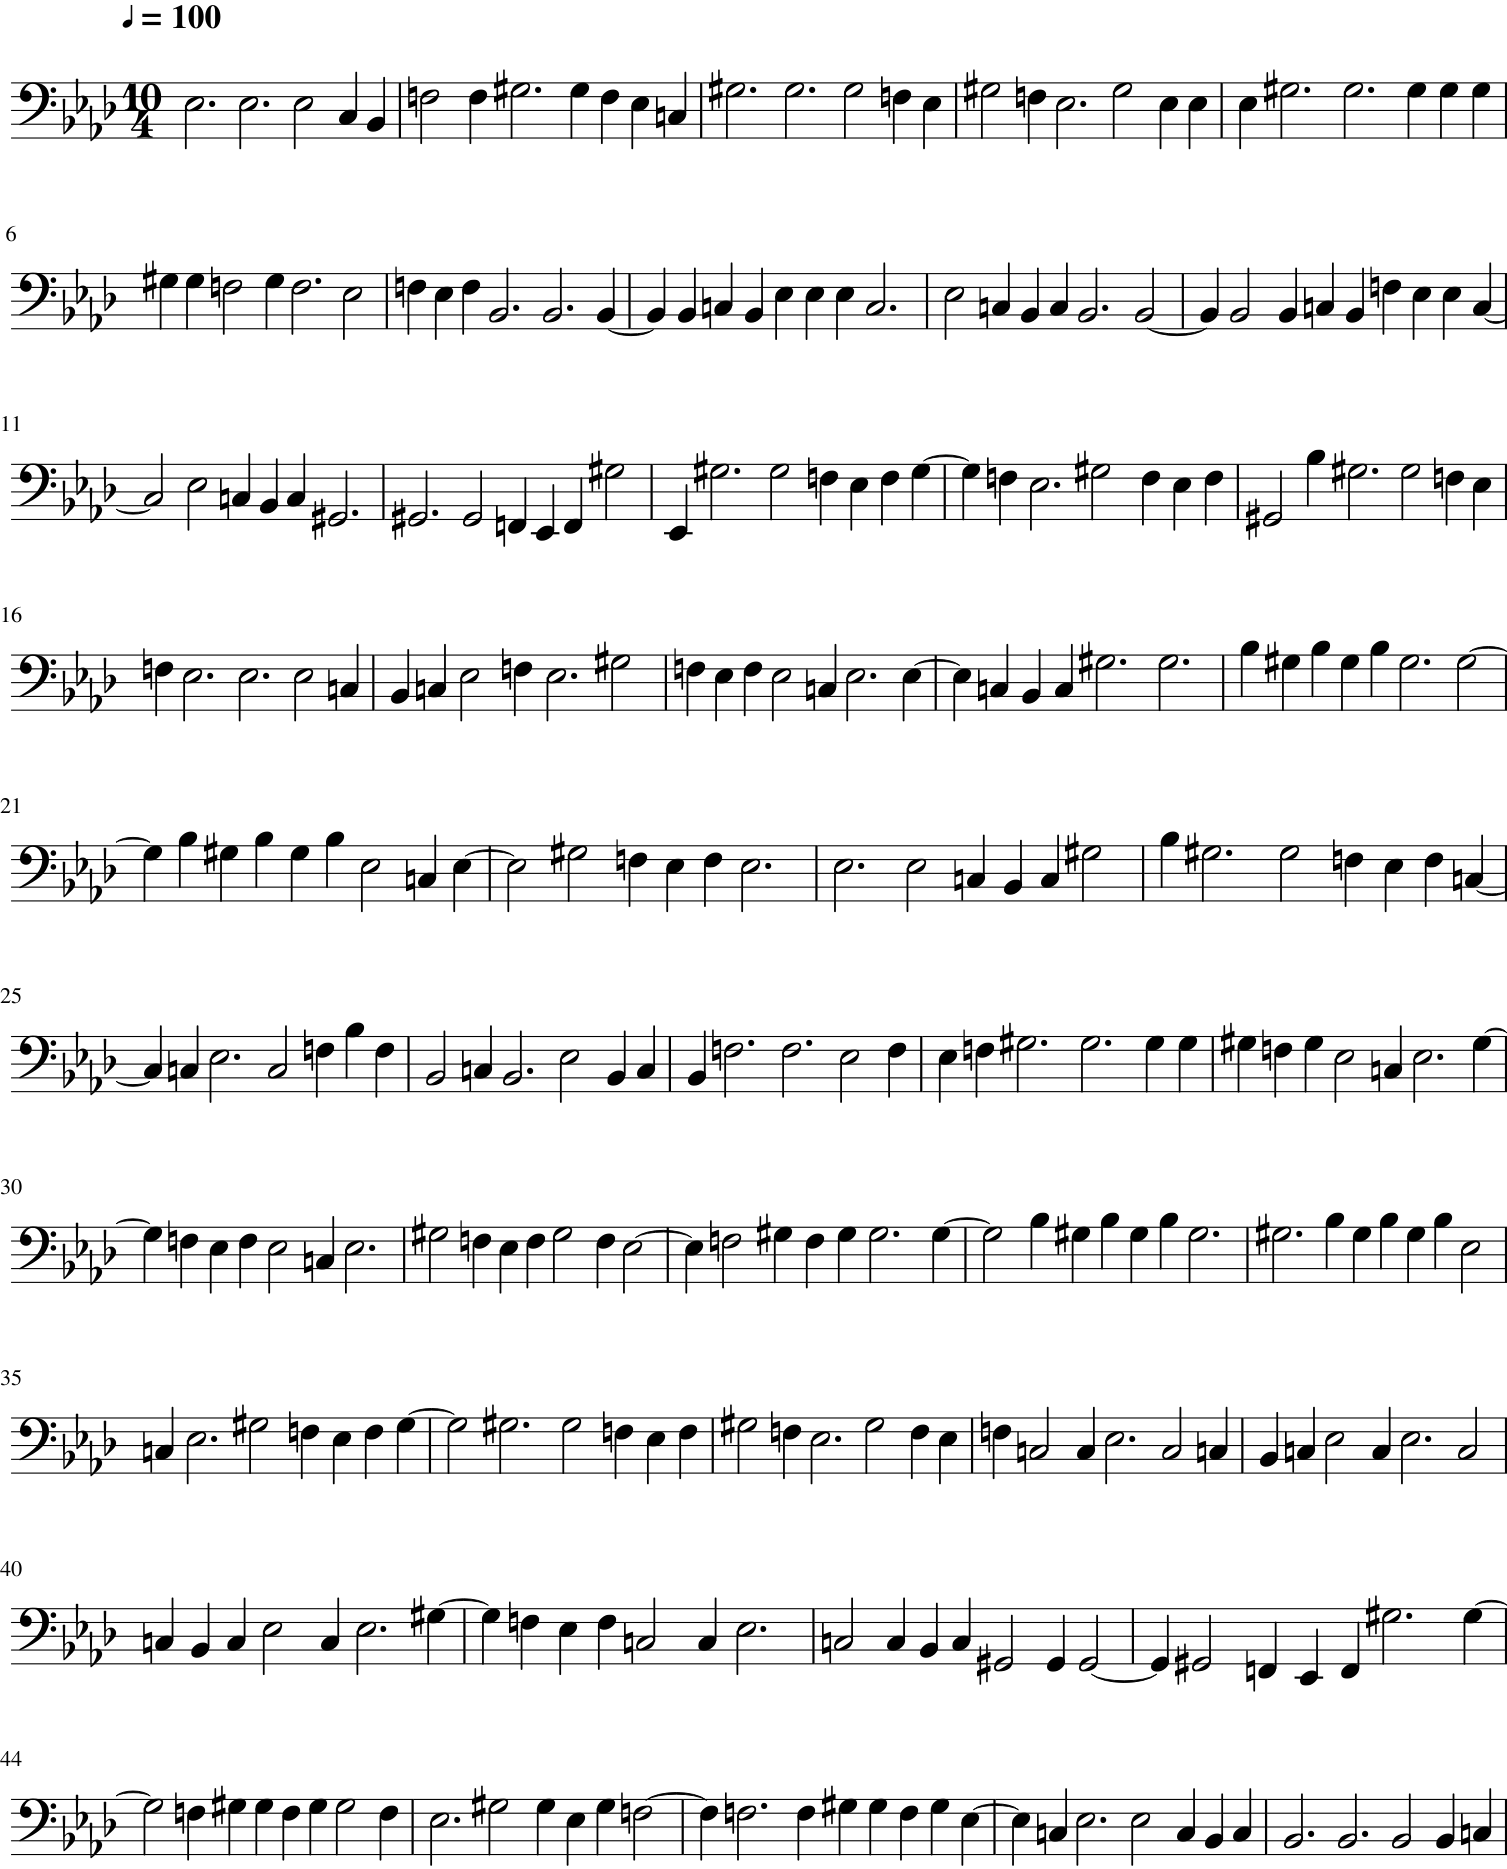

In [187]:
outputs_tensor = torch.cat(outputs, dim=0)
final_midi = decoder(model.converter(outputs_tensor))
final_midi.show()

In [8]:
def prepare_input_for_next_part(outputs_tensor):
  pred, condition = outputs_tensor[:, :3], outputs_tensor[:, 3:]
  next_input = torch.cat([torch.cat([pred[0:1], torch.tensor([[3,3,4]])], dim=1) , torch.cat([pred[1:], condition[:-1]], dim=1) ], dim=0)
  return next_input



next_input = prepare_input_for_next_part(outputs_tensor)
measure_boundary = torch.where(next_input[:, -1] == 4)[0].tolist() + [len(next_input)]
num_measures = len(measure_boundary)
num_measures


510

In [26]:
len(test_set)

506

In [11]:
test_set[0]

tensor([[ 0,  1,  1,  1,  1,  1],
        [ 0, 10, 14,  3,  3,  4],
        [ 0, 10, 12, 19,  3,  3],
        [ 0, 11, 14,  3,  3,  4],
        [ 0, 10, 12, 19,  3,  3],
        [ 0, 13, 12,  3,  3,  4],
        [ 0, 11, 10, 11,  4,  3],
        [ 0, 10, 12, 19,  3,  3],
        [ 0, 10, 14,  3,  3,  4],
        [ 0, 10, 12, 19,  3,  3],
        [ 0,  2,  2,  2,  2,  2]])

In [34]:
start_token = torch.tensor([[outputs_tensor[0,0], 1, 1, 1, 1, 1]])
end_token = torch.tensor([[outputs_tensor[0,0], 2, 2, 2 , 2, 2]])

for i in range(10):
  measure_start = measure_boundary[i]
  measure_end = measure_boundary[i+4]
  sample = next_input[measure_start:measure_end]
  sample = torch.cat([start_token, sample, end_token], dim=0)
  print(measure_start, measure_end)
  print(sample)

0 23
tensor([[ 2,  1,  1,  1,  1,  1],
        [ 2, 10, 12,  3,  3,  4],
        [ 2, 10, 12, 11,  4,  3],
        [ 2, 10, 10, 22,  3,  3],
        [ 2,  8,  7, 29,  4,  3],
        [ 2,  7,  7, 32,  5,  3],
        [ 2, 11, 10,  3,  3,  4],
        [ 2, 14,  7,  7,  5,  3],
        [ 2, 13, 12, 11,  4,  3],
        [ 2, 13, 10, 22,  3,  3],
        [ 2, 11,  7, 29,  4,  3],
        [ 2, 10,  7, 32,  5,  3],
        [ 2, 13, 10,  3,  3,  4],
        [ 2, 11,  7,  7,  5,  3],
        [ 2, 13, 12, 11,  4,  3],
        [ 2, 13, 10, 22,  3,  3],
        [ 2, 11,  7, 29,  4,  3],
        [ 2, 10,  7, 32,  5,  3],
        [ 2, 10, 10,  3,  3,  4],
        [ 2,  8,  7,  7,  5,  3],
        [ 2, 10, 12, 11,  4,  3],
        [ 2, 13, 10, 22,  3,  3],
        [ 2, 11,  7, 29,  4,  3],
        [ 2, 10,  7, 32,  5,  3],
        [ 2,  2,  2,  2,  2,  2]])
5 28
tensor([[ 2,  1,  1,  1,  1,  1],
        [ 2, 11, 10,  3,  3,  4],
        [ 2, 14,  7,  7,  5,  3],
        [ 2, 13, 12, 11,  4,  3],
   

In [10]:
from tqdm.auto import tqdm

In [11]:
start_token = torch.tensor([[outputs_tensor[0,0], 1, 1, 1, 1, 1]])
end_token = torch.tensor([[outputs_tensor[0,0], 2, 2, 2 , 2, 2]])


for target_idx in range(3, 4):
  output_by_part = []
  prev_generation = None
  outputs = []
  for i in tqdm(range(num_measures-4)):
  # for i in range(10):
    measure_start = measure_boundary[i]
    measure_end = measure_boundary[i+4]
    sample = next_input[measure_start:measure_end]
    sample = torch.cat([start_token, sample, end_token], dim=0)
    src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, target_idx, prev_generation=prev_generation)
    output_midi = decoder(output_decoded)
    if prev_generation is not None:
      new_out = new_out[1:]
    outputs.append(new_out)
    print(i, (new_out[:,-1]==4).sum().item())
    prev_generation = get_measure_shifted_output(output)

  # outputs_tensor = torch.cat(outputs, dim=0)
  # next_input = prepare_input_for_next_part(outputs_tensor)
  # measure_boundary = torch.where(next_input[:, -1] == 4)[0]
  # num_measures = len(measure_boundary)
  # output_by_part.append(outputs_tensor)
  # final_midi = decoder(model.converter(outputs_tensor))
  # final_midi.write('midi', f'sequential_inference_CPH_{target_idx}.mid')


  0%|          | 0/506 [00:00<?, ?it/s]

0 4
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1
153 1
154 1
155 1
156 1
157 1
158 1
159 1
160 1
161 1
162 1
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 1
173 1
174 1
175 1
176 1
177 1
178 1
179 1
180 1
181 1
182 1
183 1
184 1


In [16]:
len(outputs)

1012

In [12]:
new_outputs_tensor = torch.cat(outputs, dim=0)
n_next_input = prepare_input_for_next_part(new_outputs_tensor)
n_measure_boundary = torch.where(n_next_input[:, -1] == 4)[0]
len(n_measure_boundary)


1018

In [21]:
num_measures

1089

In [17]:
new_out, prev_generation

(tensor([[ 3, 13, 10,  7,  5,  3],
         [ 3, 14,  7, 11,  4,  3],
         [ 3, 13, 12, 22,  3,  3],
         [ 3, 13, 10, 29,  4,  3],
         [ 3, 13,  7, 32,  5,  3],
         [ 3, 10,  7,  3,  3,  4]]),
 tensor([[ 3,  1,  1,  3,  3,  4],
         [ 3,  6, 10,  7,  5,  3],
         [ 3,  5,  7, 11,  4,  3],
         [ 3,  6, 12, 22,  3,  3],
         [ 3,  6, 10, 29,  4,  3],
         [ 3,  5,  7, 32,  5,  3],
         [ 3,  5,  7,  3,  3,  4],
         [ 3, 11, 12, 11,  4,  3],
         [ 3, 11, 12, 22,  3,  3],
         [ 3, 11, 10, 29,  4,  3],
         [ 3, 11,  7, 32,  5,  3],
         [ 3, 11,  7,  3,  3,  4],
         [ 3, 13, 10,  7,  5,  3],
         [ 3, 14,  7, 11,  4,  3],
         [ 3, 13, 12, 22,  3,  3],
         [ 3, 13, 10, 29,  4,  3],
         [ 3, 13,  7, 32,  5,  3]]))

torch.Size([5867, 6])

In [250]:
measure_boundary

tensor([    0,     5,    12,  ..., 33415, 33416, 33422])

In [ ]:
pred, condition = [note[:3] for note in output], [note[3:] for note in output]
output = [pred[0] + [0, 'strong', 0]] + [pr + con for pr, con in zip(pred[1:], condition[:-1])] + [[output_part_idx, 'end', 'end', 'end', 'end', 'end']]
output = [[output_part_idx, 'start', 'start', 'start', 'start', 'start']] + output
sample = [val_dataset.tokenizer(note) for note in output]
sample = torch.Tensor(sample).long()


In [188]:
final_midi.write('midi', fp='shifted_inference_entire_cph.mid')

'shifted_inference_entire_cph.mid'

In [58]:
prev_generation

tensor([[ 2,  1,  1,  3,  3,  4],
        [ 2, 11, 10,  7,  5,  3],
        [ 2, 14,  7, 11,  4,  3],
        [ 2, 13, 12, 22,  3,  3],
        [ 2, 13, 10, 29,  4,  3],
        [ 2, 11,  7, 32,  5,  3],
        [ 2, 10,  7,  3,  3,  4],
        [ 2, 13, 12, 11,  4,  3],
        [ 2, 13, 12, 22,  3,  3],
        [ 2, 13,  7, 25,  5,  3],
        [ 2, 11,  7, 29,  4,  3],
        [ 2, 10,  7, 32,  5,  3],
        [ 2,  8,  7,  3,  3,  4],
        [ 2, 10, 12, 11,  4,  3],
        [ 2, 10, 12, 22,  3,  3],
        [ 2, 10, 10, 29,  4,  3],
        [ 2,  8,  7, 32,  5,  3],
        [ 2, 10, 10,  7,  5,  3],
        [ 2,  8,  7, 11,  4,  3],
        [ 2, 10, 12, 22,  3,  3],
        [ 2, 13, 10, 29,  4,  3],
        [ 2, 13,  7, 32,  5,  3]])

In [57]:
outputs

[tensor([[ 2, 10, 12, 11,  4,  3],
         [ 2, 10, 12, 22,  3,  3],
         [ 2, 10, 10, 29,  4,  3],
         [ 2,  8,  7, 32,  5,  3],
         [ 2,  7,  7,  3,  3,  4],
         [ 2, 11, 10,  7,  5,  3],
         [ 2, 14,  7, 11,  4,  3],
         [ 2, 13, 12, 22,  3,  3],
         [ 2, 13, 10, 29,  4,  3],
         [ 2, 11,  7, 32,  5,  3],
         [ 2, 10,  7,  3,  3,  4],
         [ 2, 13, 12, 11,  4,  3],
         [ 2, 13, 12, 22,  3,  3],
         [ 2, 13,  7, 25,  5,  3],
         [ 2, 11,  7, 29,  4,  3],
         [ 2, 10,  7, 32,  5,  3],
         [ 2,  8,  7,  3,  3,  4],
         [ 2, 10, 12, 11,  4,  3],
         [ 2, 10, 12, 22,  3,  3],
         [ 2, 10, 10, 29,  4,  3],
         [ 2,  8,  7, 32,  5,  3],
         [ 2,  7,  7,  3,  3,  4]]),
 tensor([[ 2, 10, 10,  7,  5,  3],
         [ 2,  8,  7, 11,  4,  3],
         [ 2, 10, 12, 22,  3,  3],
         [ 2, 13, 10, 29,  4,  3],
         [ 2, 13,  7, 32,  5,  3],
         [ 2, 14,  7,  3,  3,  4]])]

In [34]:
part_idx = prev_generation[0,0]
src = test_set[1]
sample[:,0] = 1
self = model

with torch.inference_mode():
    encode_out, encode_last_hidden = self.encoder(src.unsqueeze(0)) # 

    # Setup for 0th step
    start_token = torch.LongTensor([[part_idx, 1, 1, 3, 3, 4]]) # start token idx is 1
    assert src.ndim == 2 # sequence length, feature length
    #-------------
    not_triplet_vocab_list = [ i for i, dur in enumerate(self.vocab.vocab['duration'][3:], 3) if (dur%0.5) != 0.0]
    #-------------
    measure_duration = self.vocab.measure_duration[part_idx]
    # current_measure_idx = 0
    measure_changed = 1

    last_hidden = encode_last_hidden
    if last_hidden.shape[-1] != self.decoder.gru_size:
      last_hidden = self.decoder.reduce_enc(last_hidden)

    if prev_generation is not None:
      emb = self.decoder._get_embedding(prev_generation)
      decode_out, last_hidden = self.decoder.rnn(emb.unsqueeze(0), last_hidden)
      start_token = torch.cat([prev_generation[-1:, :3],  torch.LongTensor([[3, 3, 4]])], dim=-1)
      print("start token is changed to", start_token)
    selected_token = start_token
    current_beat = 0.0

    final_tokens = []
    total_attention_weights = []
    # while True:

    for i in range(300):
      emb = self.decoder._get_embedding(selected_token)
      decode_out, last_hidden = self.decoder.rnn(emb.unsqueeze(0), last_hidden)
      attention_vectors, attention_weight = self._get_attention_vector(encode_out, decode_out)
      combined_value = torch.cat([decode_out, attention_vectors], dim=-1)
      selected_token = self.decoder.sampling_process(combined_value, not_triplet_vocab_list)
      
      if selected_token[0, 0]==self.vocab.tok2idx['pitch']['end'] or selected_token[0, 1]==self.vocab.tok2idx['duration']['end']:
        break
      
      # update beat position and beat strength
      current_dur = self.vocab.vocab['duration'][selected_token[0, 1]]
      if current_dur in ('start', 'pad'):
        current_dur = 0.0
      current_beat += current_dur
      if current_beat >= measure_duration:
        # current_measure_idx += 1 #마디 수 늘려주기
        measure_changed = 1
        current_beat = current_beat - measure_duration
      else:
        measure_changed = 0
      
      measure_offset_idx = self.vocab.tok2idx['offset'][current_beat]
      dynamic = get_dynamic(current_beat, part_idx)
      dynamic_idx = self.vocab.tok2idx['dynamic'][dynamic]
      measure_idx = self.vocab.tok2idx['measure_change'][measure_changed]
      # print("line 634", current_beat, current_measure_idx, measure_offset_idx, measure_idx)
      # make new token for next rnn timestep
      selected_token = torch.cat([torch.LongTensor([[part_idx]]), selected_token, torch.LongTensor([[measure_offset_idx, dynamic_idx, measure_idx]])], dim=1)
      
      final_tokens.append(selected_token)
      total_attention_weights.append(attention_weight[0,:,0])
    attention_map = torch.stack(total_attention_weights, dim=1)
    cat_out = torch.cat(final_tokens, dim=0)
    if prev_generation is not None:
      cat_out = torch.cat([prev_generation, cat_out], dim=0)
    #  self.converter(src[1:-1]), self.converter(torch.cat(final_tokens, dim=0)), attention_map

    return self.converter(src[1:-1]), self.converter(cat_out), cat_out

start token is changed to tensor([[2, 8, 7, 3, 3, 4]])
end token is selected


tensor([[ 2, 10,  7,  5,  5,  3],
        [ 2, 10,  7,  7,  5,  3],
        [ 2, 10,  7, 11,  4,  3],
        [ 2, 10, 12, 22,  3,  3],
        [ 2, 13, 10, 29,  4,  3],
        [ 2, 13,  7, 32,  5,  3],
        [ 2, 13,  7,  3,  3,  4]])

In [31]:
start_token

tensor([[2, 8, 7, 3, 3, 4]])

In [21]:
out_midi.write('midi', fp='sequential_inference.mid')

'sequential_inference.mid'

In [ ]:
test_set.measure_features[0]

In [ ]:
# state = torch.load('best_model.pt')
state = torch.load('outputs/2023-12-01/00-58-58/best_model.pt')
model.load_state_dict(state)

In [ ]:
trainer = Trainer(model=model, optimizer=None, 
                  loss_fn=None, train_loader=valid_loader, 
                  valid_loader=valid_loader, device = device, save_log=False)

trainer.make_inference_result()

### 단일

In [ ]:
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate)
model.to('cpu')
val_part_idx_info = defaultdict(list)
for i, val in enumerate(val_dataset):
    val_part_idx_info[int(val[0][0][0])].append(i)
val_part_idx_info

In [ ]:

def get_similarity_with_inference(src, output, dynamic_templates):
  sampled_src = convert_note_to_sampling(src, dynamic_templates)
  smpled_output = convert_note_to_sampling(output, dynamic_templates)
  
  measure_similarity = sum([note_1[1]==note_2[1] for note_1, note_2 in zip(sampled_src, smpled_output)])/len(sampled_src)

  return measure_similarity

def get_correspondence_with_inference(src, output, dynamic_templates):
  sampled_src = convert_note_to_sampling(src, dynamic_templates)
  smpled_output = convert_note_to_sampling(output, dynamic_templates)
  strong_beat_a, strong_beat_b = [], []
  for j, note in enumerate(sampled_src):
    if note[3] in ['strong', 'middle']:
      strong_beat_a.append(note[1])
  for j, note in enumerate(smpled_output):
    if note[3] in ['strong', 'middle']:
      strong_beat_b.append(note[1])  
  measure_correspondence = sum([strong_beat_a[idx]==strong_beat_b[idx] for idx in range(len(strong_beat_a))])/len(strong_beat_a)
  return measure_correspondence

In [ ]:
import matplotlib.pyplot as plt
valid_dataset_idx = 56
output_part_idx = 7

sample = valid_loader.dataset[valid_dataset_idx][0]
# src, output, attention_map = model.inference(sample, output_part_idx)ㅂ3ㄱ 
src, output, attention_map = model.shifted_inference(sample, output_part_idx)

decoder = MidiDecoder(valid_loader)
src_midi = decoder(src)
output_midi = decoder(output)

dynamic_templates = make_dynamic_template(offset_list=val_dataset.offset_list)
get_similarity_with_inference(src, output, dynamic_templates), get_correspondence(src, output, dynamic_templates)
# merged_midi = stream.Stream()
# for element in src_midi:
#     merged_midi.append(element)
# for element in output_midi:
#     merged_midi.append(element)

# merged_midi.write('musicxml.png', "source_and_output.png")

In [ ]:
val_dataset.offset_list

In [ ]:
sum([note[2] for note in src]) == sum([note[2] for note in output]) 
  

In [ ]:
[] + [True]+ [False] + [True]

## 순서대로!

In [ ]:
valid_dataset_idx = 5
output_part_idx = 1
decoder = MidiDecoder(valid_loader)
merged_midi = stream.Stream()
sample = valid_loader.dataset[valid_dataset_idx][0]

for i in range(7):    
  src, output, attention_map = model.shifted_inference(sample, output_part_idx)
  if i == 0:
    src_midi = decoder(src)
    for element in src_midi:
      merged_midi.append(element)
  print(i)
  output_midi = decoder(output)
  for element in output_midi:
    merged_midi.append(element)
  pred, condition = [note[:3] for note in output], [note[3:] for note in output]
  output = [pred[0] + [0, 'strong', 0]] + [pr + con for pr, con in zip(pred[1:], condition[:-1])] + [[i+1, 'end', 'end', 'end', 'end', 'end']]
  output = [[i+1, 'start', 'start', 'start', 'start', 'start']] + output
  sample = [val_dataset.tokenizer(note) for note in output]
  sample = torch.Tensor(sample).long()
  print(sample)
  output_part_idx += 1

merged_midi.write('musicxml.png', "source_and_output.png")


# src, output, attention_map = model.inference(sample, output_part_idx)







In [ ]:
merged_midi.show()

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(attention_map)

In [ ]:
sample